# Spam detector

Supervised Learning. Binary classification

Goal: Predict the probability that a given email is a spam email

Data from [Applied Text Mining in Python | Coursera](https://www.coursera.org/learn/python-text-mining/)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

## 1. Data Processing

In [2]:
df = pd.read_csv('data/spam.csv')

print("{} rows \n{} columns".format(*df.shape))

df.head(3)

5572 rows 
2 columns


,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam


### Explore and Clean the target

In [3]:
print(df['target'].squeeze().value_counts(dropna=False))

ham     4825
spam     747
Name: target, dtype: int64


In [4]:
# change ()'ham', 'spam') to (0,1)
df['target'] = np.where(df['target'] == 'spam', 1, 0)

print('Ratio of email spam: {:.3f}'.format(np.mean(df['target'])))

df.head(3)

Ratio of email spam: 0.134


,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1


###  Split original data into training and test set

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['target'], random_state=0)

x_train, y_train = df_train['text'], df_train['target']
x_test, y_test = df_test['text'], df_test['target']

### Transform data

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(x_train)

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

   
vect = CountVectorizer().fit(x_train)
x_train_vectorized = vect.transform(x_train)

model = MultinomialNB(alpha=0.2)
model.fit(x_train_vectorized, y_train)

predictions = model.predict(vect.transform(x_test))  
    
print('ROC_AUC: {:.3f}'.format(roc_auc_score(y_test, predictions)))

ROC_AUC: 0.958


In [8]:
max_words = 1000

import keras

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_words, filters='')

tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Using TensorFlow backend.


In [9]:
max_length = 10

from keras.preprocessing.sequence import pad_sequences

# padding
x_train = pad_sequences(x_train, max_length)
x_test = pad_sequences(x_test, max_length)

# one-hot encoding the target
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Training set:  x-shape={}  y-shape={}".format(x_train.shape, y_train.shape))
print("Testing  set:  x-shape={}  y-shape={}".format(x_test.shape, y_test.shape))


Training set:  x-shape=(3900, 10)  y-shape=(3900, 2)
Testing  set:  x-shape=(1672, 10)  y-shape=(1672, 2)


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Embedding(max_words, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 10)            10000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 10,826
Trainable params: 10,826
Non-trainable params: 0
_________________________________________________________________


Training ....
CPU times: user 2.63 s, sys: 356 ms, total: 2.99 s
Wall time: 2.17 s


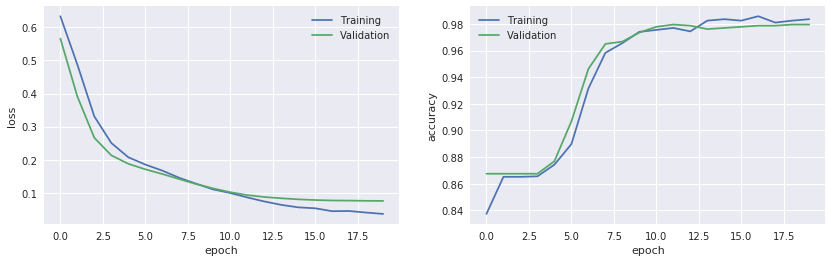


Training loss:  	0.0367
Validation loss: 	0.0759

Training accuracy: 	0.984
Validation accuracy:	0.979


In [11]:
print('Training ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1)]
%time history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, validation_split = 0.3, callbacks=callbacks)

import helper
helper.show_training(history)

#model_path = os.path.join("models", "sentiment_IMDB_model.h5")
#model.save(model_path)
#print("\nModel saved at",model_path)

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.3f}\n".format(score[1]))


Test Accuracy: 0.976



In [13]:
y_pred = model.predict(x_test)

In [14]:
from sklearn.metrics import roc_auc_score

print('Recurrent Neural Network ROC AUC test: \t{:.3f} \n'.format(roc_auc_score(y_test, y_pred)))

Recurrent Neural Network ROC AUC test: 	0.987 

